In [65]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sb

# from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [66]:
## Read the subcritical coal power plant data

sub_critical = pd.read_csv('CEEW_subcritical_with_ws_price.csv')

all_heat_rate = sub_critical['Actual SHR']* 3.96567/1000
all_capacity  = sub_critical['Capacity']
all_age       = sub_critical['Age']
all_region     = sub_critical['Region']
all_PLF        = sub_critical['Actual avg PLF']
all_water_stress = sub_critical['bws_score']
all_price = sub_critical['coal_price']

In [67]:
data = pd.DataFrame({'heat_rate': all_heat_rate,
                     'capacity': all_capacity,
                     'age': all_age, 
                     'PLF': all_PLF,
                     'water stress': all_water_stress,
                     'region': all_region,
                     'price': all_price
                     })

# change the state to one hot encoding
data = pd.get_dummies(data, columns=['region']) # aggregate the states here. 

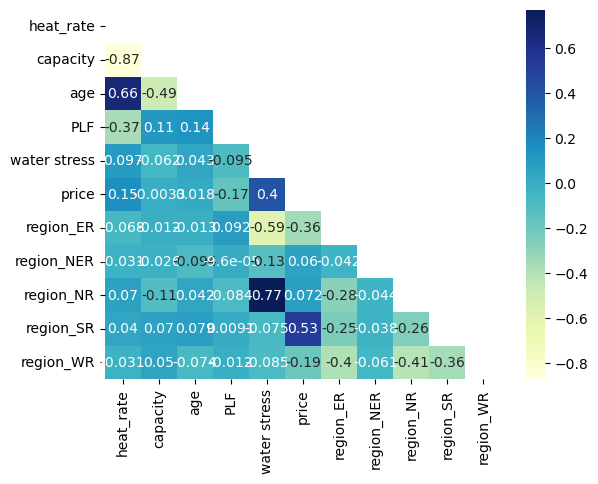

In [68]:
mask = np.triu(np.ones_like(data.corr()))
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.savefig('ML_training_plots/Feature_correlation_sub.png', bbox_inches='tight')

2. Fit the prediction model using data

In [69]:
X = data.drop('heat_rate', axis=1)
y = data['heat_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# add constant
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [70]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge

In [71]:
good_models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.1, loss='absolute_error', max_depth=15, n_estimators=200),
    'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=400)
}

In [72]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

In [73]:
# Cross validation
kf = KFold(n_splits=5)
res1 = {}
res2 = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# use mean squared error, mean absolute error, mean absolute percentage error
for name, model in good_models.items():
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error',
                                                                     'neg_mean_absolute_percentage_error', 'r2'))
    scores1 = cross_validate(model, X_test, y_test, cv=kf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error',
                                                                     'neg_mean_absolute_percentage_error', 'r2'))
    res1[name] = scores
    res2[name] = scores1

In [74]:
diff1 = (-res1['GradientBoostingRegressor']['test_neg_mean_squared_error'] - (-res1['XGBRegressor']['test_neg_mean_squared_error']))
diff2 = (-res2['GradientBoostingRegressor']['test_neg_mean_squared_error'] - (-res2['XGBRegressor']['test_neg_mean_squared_error']))
diff = (diff1+diff2) * 0.5
score1 = diff1[0] 
print('Performance difference in five folds: ', diff)

#Compute the mean of differences
d_bar = np.mean(diff) 
#compute the variance of differences
sigma2 = np.var(diff) 
#compute the number of data points used for training 
k = 5
#compute the t_static
t_static =  score1 * np.sqrt(k) / np.sqrt(sigma2)
print('The t-value is ', abs(t_static))


Performance difference in five folds:  [ 0.00080701  0.00132767 -0.00102003  0.00704969 -0.00753214]
The t-value is  2.971551695714478 2.971551695714478
